In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

C:\Users\Noblesse\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part 1

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Shwo the datatype
df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [6]:
# Insert a dummy column called 'total'
df.insert(column='total', value=1, loc=1)
df.head()

,login_time,total
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [7]:
# Aggregate and sum the dummy column 'total' by 15 mins interval
df_agg = pd.DataFrame(df.set_index('login_time').resample('15Min')['total'].sum().reset_index())
df_agg.head()

,login_time,total
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [8]:
# Create a separate column which contains time from 'login_time'
df_agg.insert(column='time', value=df_agg['login_time'].dt.time, loc=1)
df_agg.head()

,login_time,time,total
0,1970-01-01 20:00:00,20:00:00,2
1,1970-01-01 20:15:00,20:15:00,6
2,1970-01-01 20:30:00,20:30:00,9
3,1970-01-01 20:45:00,20:45:00,7
4,1970-01-01 21:00:00,21:00:00,1


In [9]:
# Drop 'login_time'
df_agg.drop('login_time', axis=1, inplace=True)

In [10]:
# Groupby 'time'
df_agg = df_agg.groupby('time').first()
df_agg.head()

,total
time,
00:00:00,10
00:15:00,18
00:30:00,12
00:45:00,13
01:00:00,9


In [11]:
# Show that we have proper time for the index
df_agg.index

Index([00:00:00, 00:15:00, 00:30:00, 00:45:00, 01:00:00, 01:15:00, 01:30:00,
       01:45:00, 02:00:00, 02:15:00, 02:30:00, 02:45:00, 03:00:00, 03:15:00,
       03:30:00, 03:45:00, 04:00:00, 04:15:00, 04:30:00, 04:45:00, 05:00:00,
       05:15:00, 05:30:00, 05:45:00, 06:00:00, 06:15:00, 06:30:00, 06:45:00,
       07:00:00, 07:15:00, 07:30:00, 07:45:00, 08:00:00, 08:15:00, 08:30:00,
       08:45:00, 09:00:00, 09:15:00, 09:30:00, 09:45:00, 10:00:00, 10:15:00,
       10:30:00, 10:45:00, 11:00:00, 11:15:00, 11:30:00, 11:45:00, 12:00:00,
       12:15:00, 12:30:00, 12:45:00, 13:00:00, 13:15:00, 13:30:00, 13:45:00,
       14:00:00, 14:15:00, 14:30:00, 14:45:00, 15:00:00, 15:15:00, 15:30:00,
       15:45:00, 16:00:00, 16:15:00, 16:30:00, 16:45:00, 17:00:00, 17:15:00,
       17:30:00, 17:45:00, 18:00:00, 18:15:00, 18:30:00, 18:45:00, 19:00:00,
       19:15:00, 19:30:00, 19:45:00, 20:00:00, 20:15:00, 20:30:00, 20:45:00,
       21:00:00, 21:15:00, 21:30:00, 21:45:00, 22:00:00, 22:15:00, 22:30:00,

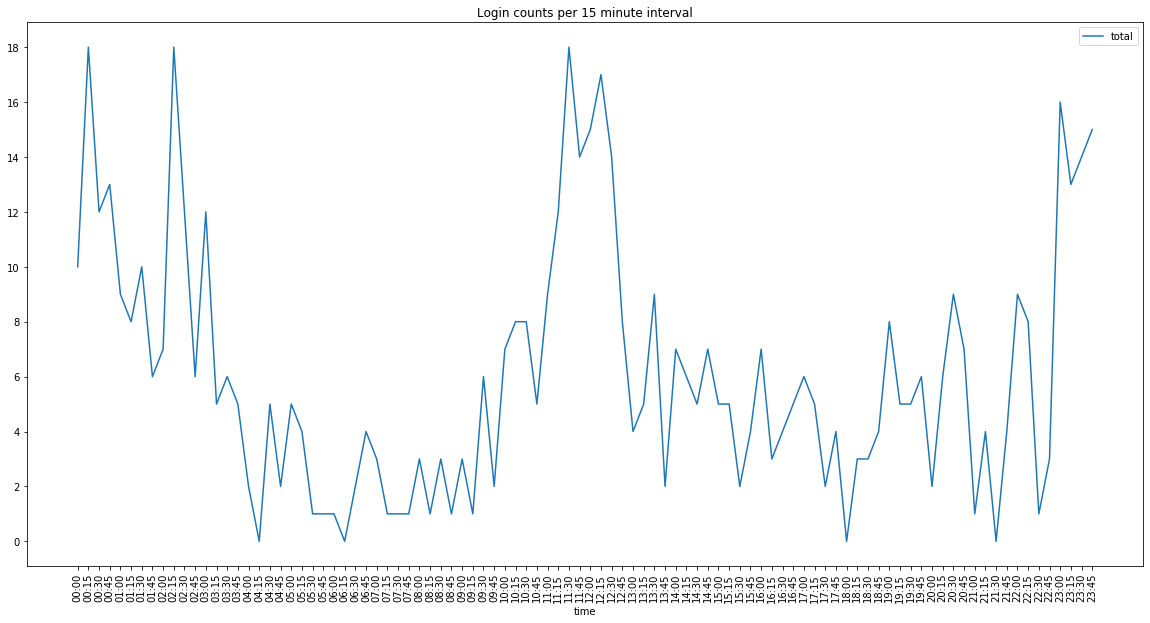

In [12]:
# Plot the login counts per 15 minute interval
df_agg.plot(figsize=(20, 10))
plt.xticks(df_agg.index, rotation=90)
plt.yticks(np.arange(0, 20, 2))
plt.title('Login counts per 15 minute interval')
plt.show()

In [13]:
# Make a copy of the df dataframe
df_weekday = df.copy()

In [14]:
# Create a column which contains the weekday
df_weekday.insert(column='weekday', value=df_weekday['login_time'].dt.weekday, loc=1)
df_weekday.head()

,login_time,weekday,total
0,1970-01-01 20:13:18,3,1
1,1970-01-01 20:16:10,3,1
2,1970-01-01 20:16:37,3,1
3,1970-01-01 20:16:36,3,1
4,1970-01-01 20:26:21,3,1


In [15]:
# Drop the 'login_time' column
df_weekday.drop('login_time', axis=1, inplace=True)

In [16]:
# Groupby weekday and sum
df_weekday = df_weekday.groupby('weekday').sum()
df_weekday

,total
weekday,
0,8823
1,9268
2,10339
3,11960
4,15208
5,19377
6,18167


In [17]:
# Define weekdays
days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

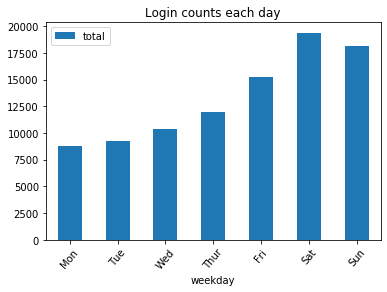

In [18]:
# Plot login counts for each weekday
df_weekday.plot(kind='bar')
plt.xticks(ticks=np.arange(0, 7, 1), labels=days, rotation=50)
plt.title('Login counts each day')
plt.show()

In [19]:
# Make a copy of the df dataframe
df_month = df.copy()

In [20]:
# Insert a column containing month
df_month.insert(column='month', value=df_month['login_time'].dt.month ,loc=1)

In [21]:
df_month.head()

,login_time,month,total
0,1970-01-01 20:13:18,1,1
1,1970-01-01 20:16:10,1,1
2,1970-01-01 20:16:37,1,1
3,1970-01-01 20:16:36,1,1
4,1970-01-01 20:26:21,1,1


In [22]:
# Drop 'login_time' column
df_month.drop('login_time', axis=1, inplace=True)

In [23]:
# Aggregate and sum by month
df_month = df_month.groupby('month').sum()
df_month

,total
month,
1,21239
2,24673
3,33723
4,13507


In [24]:
month = ['Jan', 'Feb', 'Mar', 'Apr']

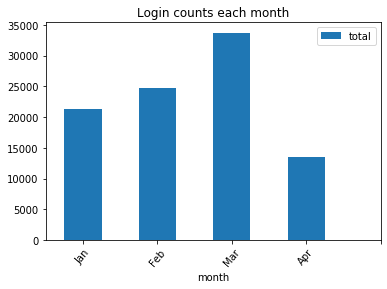

In [25]:
df_month.plot(kind='bar')
plt.xticks(ticks=np.arange(0, 5, 1), labels=month, rotation=50)
plt.title('Login counts each month')
plt.show()

# Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

> To measure how success of this experiment, you would calculate the reimbursed toll prices. Since the reimbursement would only occur to the driver partners and not to anyone else, the price will be very easy to isolate. By comparing the reimbursed toll cost before and after, we will be able to tell how often the driver partners were active in both cities.

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:



- a. how you will implement the experiment

> If we record the time occurred for all the reimbursed tolls, we can tell how often the citizens used the driver partners to visit the other city. Since the statement does mention that the driver partners are exclusive to each city, and this will be a new concept to the citizens, we will have to take the data for a set period of time. After comparing the prices between the reimbursed toll cost vs. toll cost (from everyone else but driver partners). We can then observe if citizens in both cities use these driver partners to travel to a different city. We will also be able to tell when the most active day and time is.

- b. what statistical test(s) you will conduct to verify the significance of the
observation

> Regression analysis. We will determine the effect of independent variable (time) on a target variable (price). We would see if the reimbursed toll costs rose over time, remained the same, or etc. For the time we can compare day-to-day and hour-to-hour to see if there are any patterns.

- c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

> If the linear regression is postive, then we can conclude that the citizens are willing to use driver partners to visit the other city continuously. If the linear regression is negative, then I will tell the driver partners that something is wrong and they are losing their customers over time. The caveat I will provide them are since the data collected on reimbursed cost isn't long enough, there could be unforseen factors that could hurt the market in the future.

# Part 3

In [26]:
# Load the Json datset
df_ult = pd.read_json('ultimate_data_challenge.json')

In [27]:
# See the first five rows
df_ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
# Display the column datatypes
df_ult.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [29]:
# Show how many null values and which columns contain null values
df_ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

##### Since we do not know when the data was pulled, we have to use the latest date from 'last_trip_date' as the latest date and use that to see if the user has been active 30 days prior to that.

In [30]:
# Change the signup date and last trip date to datetime dtype
df_ult['signup_date'] = pd.to_datetime(df_ult['signup_date'])
df_ult['last_trip_date'] = pd.to_datetime(df_ult['last_trip_date'])

In [31]:
# What is the latest date recorded for the trip date?
df_ult.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [32]:
# Add a dummy column with the latest date
df_ult['latest_date'] = '2014-07-01'
df_ult['latest_date'] = pd.to_datetime(df_ult['latest_date'])

In [33]:
# Calculate the date difference between the latest date and the last trip date
df_ult['last_active'] = (df_ult['latest_date'] - df_ult['last_trip_date']).dt.days
df_ult.drop('latest_date', axis=1, inplace=True)

In [34]:
df_ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108


In [35]:
# Separate the dataframe into active and inactive users
df_inactive = df_ult.loc[df_ult['last_active'] >= 30]
df_active = df_ult.loc[df_ult['last_active'] < 30]

In [36]:
df_active.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,25
13,King's Landing,0,2014-01-29,4.0,1.38,2014-06-08,iPhone,50.0,False,50.0,3.04,5.0,23
16,King's Landing,1,2014-01-11,5.0,1.00,2014-06-28,Android,0.0,True,50.0,10.86,3.0,3


In [37]:
df_inactive.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0,157
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,153


In [38]:
print('There are {} active users in the last 30 days'.format(len(df_active)))
print('There are {} inactive users who has not used the service in the last 30 days'.format(len(df_inactive)))

There are 18310 active users in the last 30 days
There are 31690 inactive users who has not used the service in the last 30 days


In [39]:
# Add a column in each active and inactive dataframe (0 indicates inactive, 1 indicates active users)
df_active['active'] = 1
df_inactive['active'] = 0

C:\Users\Noblesse\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Noblesse\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# Active users dataframe 
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18310 entries, 0 to 49995
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    18310 non-null  object        
 1   trips_in_first_30_days  18310 non-null  int64         
 2   signup_date             18310 non-null  datetime64[ns]
 3   avg_rating_of_driver    16742 non-null  float64       
 4   avg_surge               18310 non-null  float64       
 5   last_trip_date          18310 non-null  datetime64[ns]
 6   phone                   18180 non-null  object        
 7   surge_pct               18310 non-null  float64       
 8   ultimate_black_user     18310 non-null  bool          
 9   weekday_pct             18310 non-null  float64       
 10  avg_dist                18310 non-null  float64       
 11  avg_rating_by_driver    18276 non-null  float64       
 12  last_active             18310 non-null  int64 

### We have to take care of null values in avg_rating_of_driver, phone, and avg_rating_by_driver

In [41]:
# What is the most common phone used for active users?
df_active.phone.value_counts()

iPhone     15238
Android     2942
Name: phone, dtype: int64

In [42]:
# Replace the Null values with the most common values for 'phone' from active users
df_active.phone.fillna('iPhone', inplace=True)

C:\Users\Noblesse\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


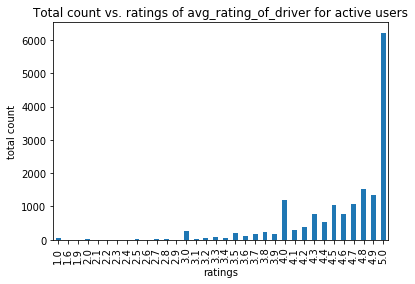

In [43]:
# Visualize the avg_rating_of_driver for active users
df_active['avg_rating_of_driver'].value_counts().sort_index(ascending='False').plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('total count')
plt.title('Total count vs. ratings of avg_rating_of_driver for active users')
plt.show()

##### The graph is not gaussian distributed, so we cannot replace the value with the mode or mean. The best option to replace the null values for the avg_rating_of_driver is using median.

In [44]:
# What is the median for the avg_rating_of_driver for active users?
df_active['avg_rating_of_driver'].median()

4.8

In [45]:
# Replace the Null values with the median for avg_rating_of_driver
df_active['avg_rating_of_driver'].fillna(4.8, inplace=True)

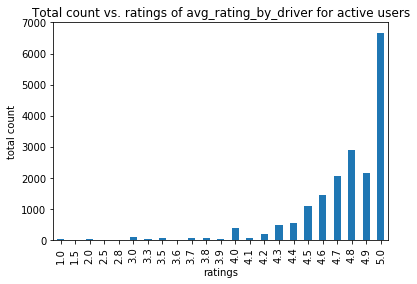

In [46]:
# Visualize the avg_rating_by_driver for active users
df_active['avg_rating_by_driver'].value_counts().sort_index(ascending='False').plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('total count')
plt.title('Total count vs. ratings of avg_rating_by_driver for active users')
plt.show()

##### Once again, the graph is not gaussian distributed, so we will replace the null values using median.

In [47]:
# What is the median for the avg_rating_by_driver for active users?
df_active['avg_rating_by_driver'].median()

4.8

In [48]:
# Replace the Null values with the median for avg_rating_of_driver
df_active['avg_rating_by_driver'].fillna(4.8, inplace=True)

In [49]:
# Make sure all the Null values are filled for the active users dataframe 
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18310 entries, 0 to 49995
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    18310 non-null  object        
 1   trips_in_first_30_days  18310 non-null  int64         
 2   signup_date             18310 non-null  datetime64[ns]
 3   avg_rating_of_driver    18310 non-null  float64       
 4   avg_surge               18310 non-null  float64       
 5   last_trip_date          18310 non-null  datetime64[ns]
 6   phone                   18310 non-null  object        
 7   surge_pct               18310 non-null  float64       
 8   ultimate_black_user     18310 non-null  bool          
 9   weekday_pct             18310 non-null  float64       
 10  avg_dist                18310 non-null  float64       
 11  avg_rating_by_driver    18310 non-null  float64       
 12  last_active             18310 non-null  int64 

### Repeat the above for inactive users dataframe

In [50]:
# Inactive users dataframe
df_inactive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31690 entries, 1 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    31690 non-null  object        
 1   trips_in_first_30_days  31690 non-null  int64         
 2   signup_date             31690 non-null  datetime64[ns]
 3   avg_rating_of_driver    25136 non-null  float64       
 4   avg_surge               31690 non-null  float64       
 5   last_trip_date          31690 non-null  datetime64[ns]
 6   phone                   31424 non-null  object        
 7   surge_pct               31690 non-null  float64       
 8   ultimate_black_user     31690 non-null  bool          
 9   weekday_pct             31690 non-null  float64       
 10  avg_dist                31690 non-null  float64       
 11  avg_rating_by_driver    31523 non-null  float64       
 12  last_active             31690 non-null  int64 

In [51]:
# What is the most common phone used for inactive users?
df_inactive.phone.value_counts() 

iPhone     19344
Android    12080
Name: phone, dtype: int64

In [52]:
# Replace the Null values with the most common values for 'phone'
df_inactive.phone.fillna('iPhone', inplace=True)

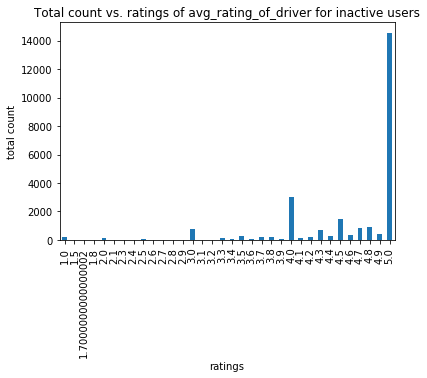

In [53]:
# Visualize the avg_rating_of_driver for inactive users
df_inactive['avg_rating_of_driver'].value_counts().sort_index(ascending='False').plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('total count')
plt.title('Total count vs. ratings of avg_rating_of_driver for inactive users')
plt.show()

##### The graph is not gaussian distributed, The best option to replace the null values for the avg_rating_of_driver is using median.

In [54]:
# What is the median for the avg_rating_of_driver for active users?
df_inactive['avg_rating_of_driver'].median()

5.0

In [55]:
# Replace the null values in avg_rating_of_driver for inactive users
df_inactive['avg_rating_of_driver'].fillna(5.0, inplace=True)

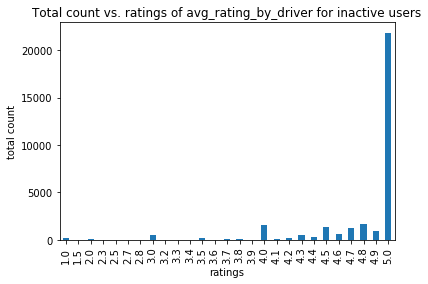

In [56]:
# Visualize the avg_rating_by_driver for inactive users
df_inactive['avg_rating_by_driver'].value_counts().sort_index(ascending='False').plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('total count')
plt.title('Total count vs. ratings of avg_rating_by_driver for inactive users')
plt.show()

In [57]:
# What is the median for the avg_rating_of_driver for active users?
df_inactive['avg_rating_by_driver'].median()

5.0

In [58]:
# Replace the null values in avg_rating_of_driver for inactive users
df_inactive['avg_rating_by_driver'].fillna(5.0, inplace=True)

In [59]:
# Make sure all the Null values are filled for the active users dataframe 
df_inactive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31690 entries, 1 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    31690 non-null  object        
 1   trips_in_first_30_days  31690 non-null  int64         
 2   signup_date             31690 non-null  datetime64[ns]
 3   avg_rating_of_driver    31690 non-null  float64       
 4   avg_surge               31690 non-null  float64       
 5   last_trip_date          31690 non-null  datetime64[ns]
 6   phone                   31690 non-null  object        
 7   surge_pct               31690 non-null  float64       
 8   ultimate_black_user     31690 non-null  bool          
 9   weekday_pct             31690 non-null  float64       
 10  avg_dist                31690 non-null  float64       
 11  avg_rating_by_driver    31690 non-null  float64       
 12  last_active             31690 non-null  int64 

In [60]:
# Concatenate the inactive and active dataframe
df_ult = pd.concat([df_inactive, df_active]).reset_index(drop=True)

In [61]:
df_ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_active,active
0,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57,0
1,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175,0
2,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108,0
3,Astapor,1,2014-01-24,5.0,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0,157,0
4,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,153,0


# Exploratory Data Analysis

In [62]:
# How many percentage of the users were retained?
print('There were {}% of users retained.'.format(len(df_active) / len(df_ult) * 100))

There were 36.620000000000005% of users retained.


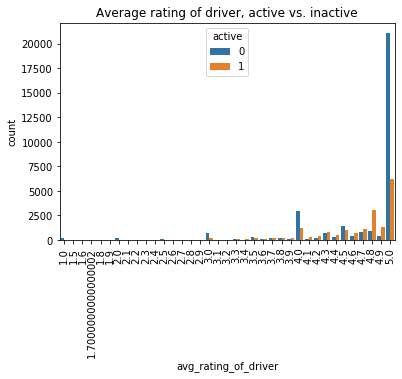

In [63]:
sns.countplot(x='avg_rating_of_driver', hue='active', data=df_ult)
plt.title('Average rating of driver, active vs. inactive')
plt.xticks(rotation='vertical')
plt.show()

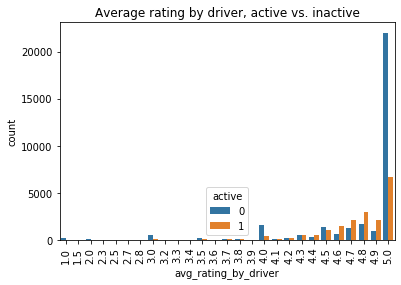

In [64]:
sns.countplot(x='avg_rating_by_driver', hue='active', data=df_ult)
plt.title('Average rating by driver, active vs. inactive')
plt.xticks(rotation='vertical')
plt.show()

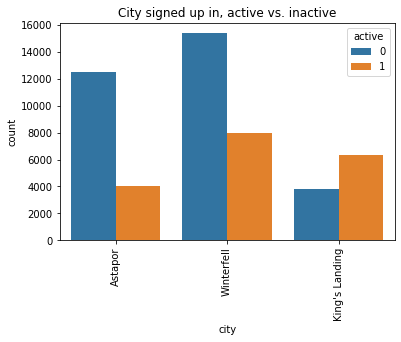

In [65]:
sns.countplot(x='city', hue='active', data=df_ult)
plt.title('City signed up in, active vs. inactive')
plt.xticks(rotation='vertical')
plt.show()

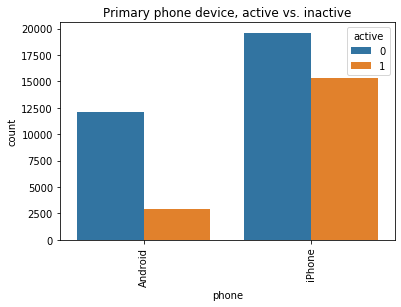

In [66]:
sns.countplot(x='phone', hue='active', data=df_ult)
plt.title('Primary phone device, active vs. inactive')
plt.xticks(rotation='vertical')
plt.show()

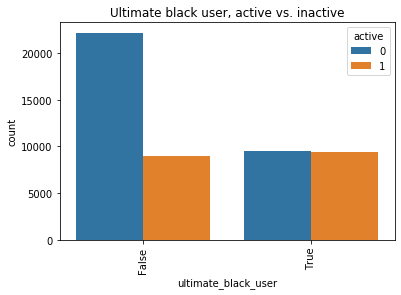

In [67]:
sns.countplot(x='ultimate_black_user', hue='active', data=df_ult)
plt.title('Ultimate black user, active vs. inactive')
plt.xticks(rotation='vertical')
plt.show()

According to this graph, the active users tend to be more ultimate black users than inactive users.

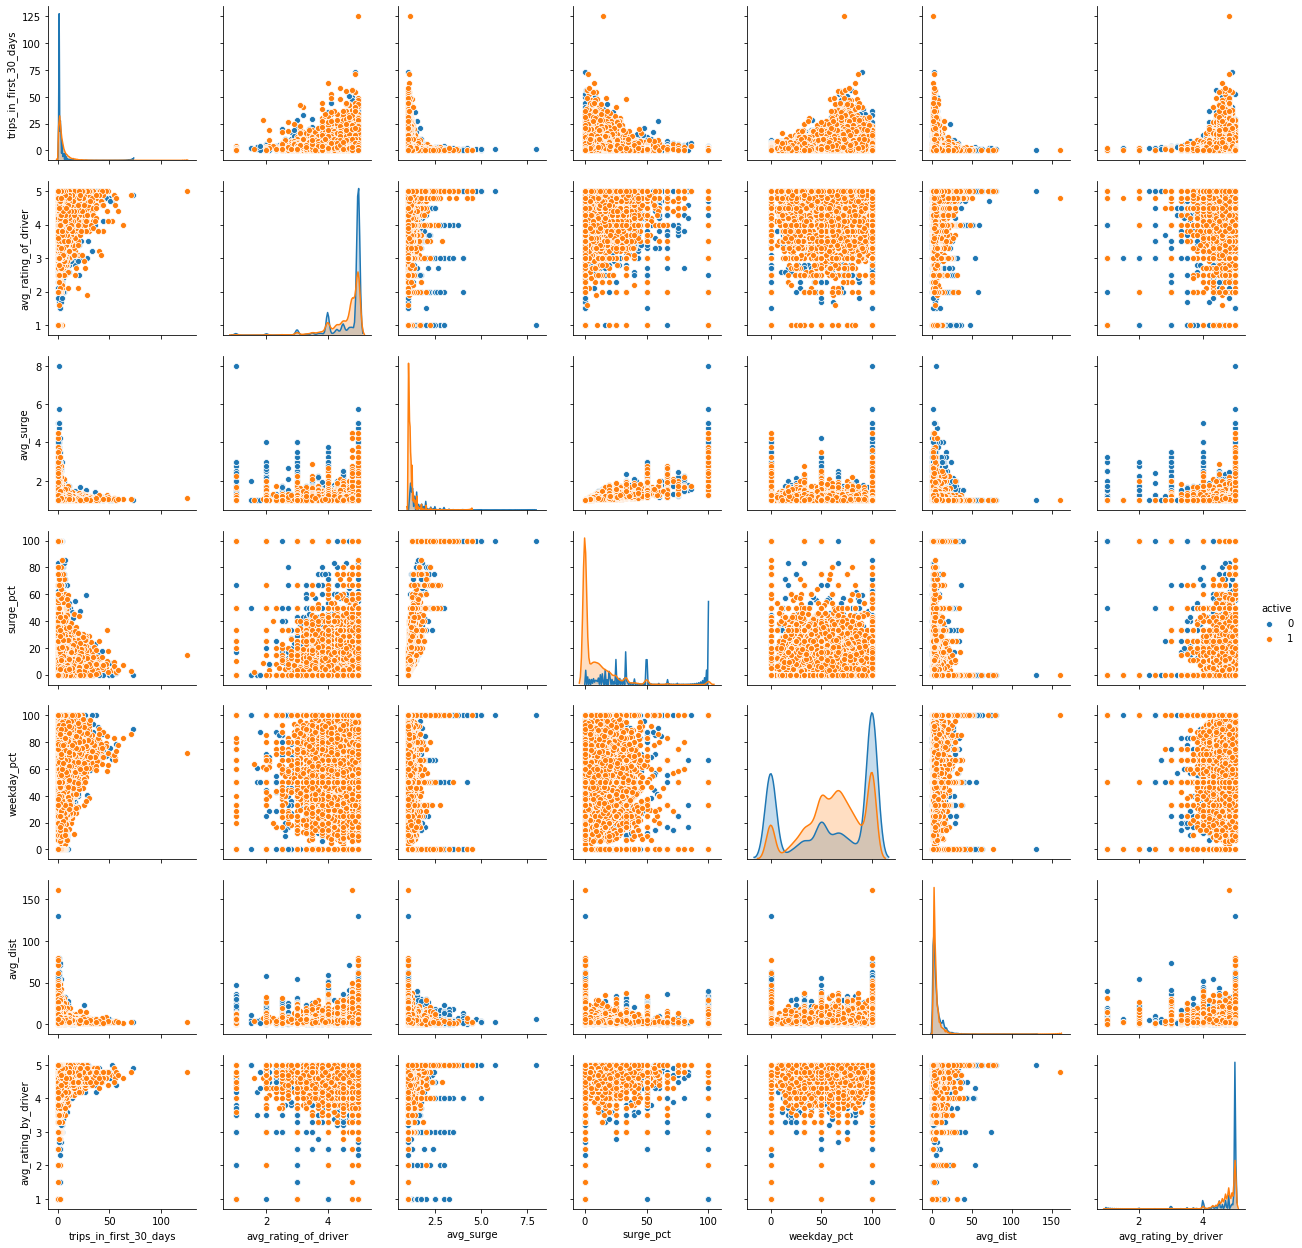

In [68]:
sns.pairplot(vars=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                   'weekday_pct', 'avg_dist', 'avg_rating_by_driver'], 
             data=df_ult, hue='active')
plt.show()

From looking at the above graphs, we cannot use any feature selection methods which assumes the normality of the distribution, such as t-test. 

In [69]:
# Drop last_active since now we have a column indicating if a user is active or not
df_ult.drop(['last_active'], axis=1, inplace=True)

Since most of the features are ordinal, we will use the spearman instead of the pearson correlation to plot the heatmap.

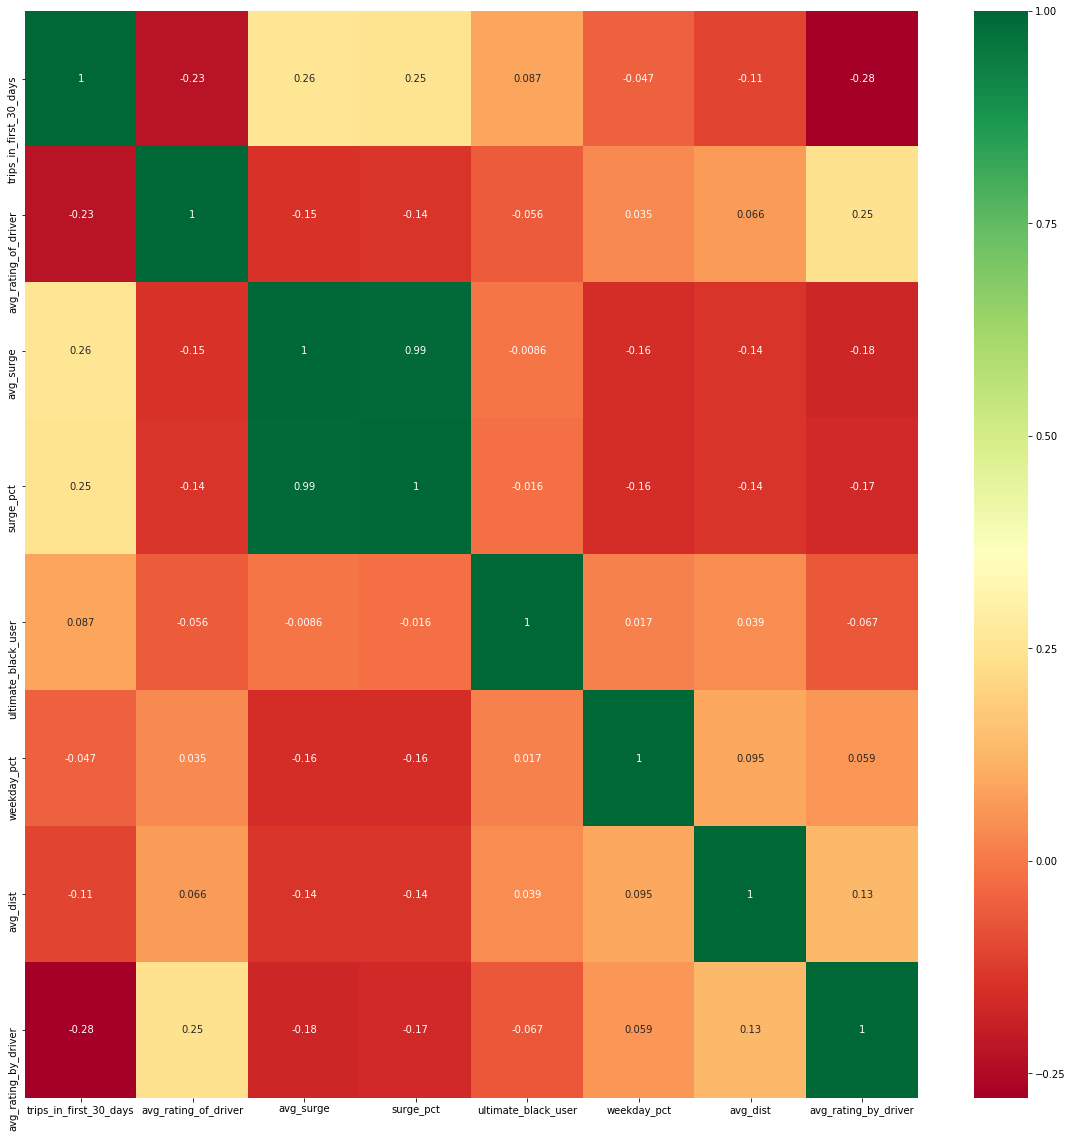

In [70]:
# Plot heatmap
plt.figure(figsize=(20,20))
sns.heatmap(df_ult.drop('active', axis=1).corr('spearman'),annot=True,cmap="RdYlGn")
plt.show()

#### There is multicolinearity detected between avg_surge and surge_pct.

In [71]:
# We will drop surge_pct
df_ult.drop('surge_pct', axis=1, inplace=True)

# Feature Selection and Machine Learning

#### We will select the features using the mlxtend's sequential forward selection.

In [72]:
df_ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,False,50.0,8.26,5.0,0
1,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,False,100.0,0.77,5.0,0
2,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,False,82.4,3.13,4.9,0
3,Astapor,1,2014-01-24,5.0,1.00,2014-01-25,Android,False,100.0,3.95,4.0,0
4,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,False,100.0,2.04,5.0,0


We can consider signup_date as ordinal only if every date are present.

In [73]:
# How many unique days are recorded in signup_date (January 2014)?
len(df_ult.signup_date.unique())

31

#### We have to drop last_trip_date because 'active' (target variable) was based on the calculation from df_ult['latest_date'] - df_ult['last_trip_date'].

In [74]:
# Drop last_trip_date
df_ult.drop('last_trip_date', axis=1, inplace=True)

### Since every date are present in both signup_date and last_trip_date, we can consider theese as ordinal and apply LabelEncoder

In [75]:
# Define LabelEncoder
le = LabelEncoder()

In [76]:
# Change the column values to LabelEncoded version
df_ult[['signup_date']] = df_ult[['signup_date']].apply(le.fit_transform)

In [77]:
df_ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,Astapor,0,28,5.0,1.00,Android,False,50.0,8.26,5.0,0
1,Astapor,3,5,4.3,1.00,iPhone,False,100.0,0.77,5.0,0
2,Winterfell,14,26,4.4,1.19,Android,False,82.4,3.13,4.9,0
3,Astapor,1,23,5.0,1.00,Android,False,100.0,3.95,4.0,0
4,Winterfell,2,27,5.0,1.00,iPhone,False,100.0,2.04,5.0,0


We also need to one hot encode 'city', 'phone', and 'ultimate_black_user' since these are nominal values.

In [78]:
dum = df_ult[['city', 'phone', 'ultimate_black_user']]
dum.head()

,city,phone,ultimate_black_user
0,Astapor,Android,False
1,Astapor,iPhone,False
2,Winterfell,Android,False
3,Astapor,Android,False
4,Winterfell,iPhone,False


In [79]:
dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 50000 non-null  object
 1   phone                50000 non-null  object
 2   ultimate_black_user  50000 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


### Remeber that 'ultimate_black_user' is boolean and won't be one hot encoded using the pandas get_dummies.

In [80]:
# Change the datatype to object from boolean
dum.ultimate_black_user = dum.ultimate_black_user.astype('object')

C:\Users\Noblesse\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [81]:
# Perform one hot encoding on the city, phone, and ultimate_black_user
dum = pd.get_dummies(data=dum)
dum.head()

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,1,0,0,1,0,1,0
1,1,0,0,0,1,1,0
2,0,0,1,1,0,1,0
3,1,0,0,1,0,1,0
4,0,0,1,0,1,1,0


In [82]:
# Create a dataframe for machine learning
# Drop the city, phone, and ultimate_black_user and replace with one hot encoded versions of them
df_ml = df_ult.drop(['city', 'phone', 'ultimate_black_user'], axis=1)
df_ml = pd.concat([dum, df_ml], axis=1)
df_ml.head()

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,weekday_pct,avg_dist,avg_rating_by_driver,active
0,1,0,0,1,0,1,0,0,28,5.0,1.00,50.0,8.26,5.0,0
1,1,0,0,0,1,1,0,3,5,4.3,1.00,100.0,0.77,5.0,0
2,0,0,1,1,0,1,0,14,26,4.4,1.19,82.4,3.13,4.9,0
3,1,0,0,1,0,1,0,1,23,5.0,1.00,100.0,3.95,4.0,0
4,0,0,1,0,1,1,0,2,27,5.0,1.00,100.0,2.04,5.0,0


# Logistic Regression

### REMEMBER! We have imbalanced dataset so we should not be using accuracy as the measure. For this, we will use f1 as the scoring metric.

In [83]:
print('There are {} inactive users'.format(len(df_inactive)))
print('There are {} active users'.format(len(df_active)))

There are 31690 inactive users
There are 18310 active users


In [84]:
# Define weight for class_weight
weight = {0: 1 , 1: (31860/18310)}

In [85]:
# Define logistic regresion model
lr = LogisticRegression(random_state=3, max_iter=5000, class_weight=weight)

In [86]:
# Define X and y then split the data into train and test set
X = df_ml.drop(['active'], axis=1)
y = df_ml['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3, stratify=y)

In [87]:
# Fit the training data
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 1.7400327689787}, max_iter=5000,
                   random_state=3)

In [88]:
# Predict the y_value
y_pred = lr.predict(X_test)

In [89]:
# Print precision, recall, f1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76     12676
           1       0.59      0.68      0.64      7324

    accuracy                           0.71     20000
   macro avg       0.70      0.71      0.70     20000
weighted avg       0.72      0.71      0.72     20000



In [90]:
# Print confusion matrix
confusion_matrix(y_test, y_pred)

array([[9276, 3400],
       [2335, 4989]], dtype=int64)

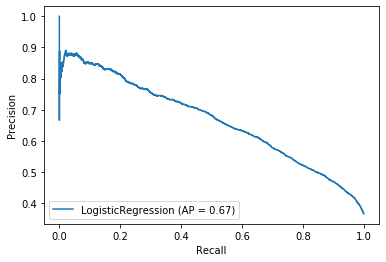

In [91]:
# Plot precision recall curve
plot_precision_recall_curve(lr, X_test, y_test)
plt.show()

## Sequential Forward Selection (Logistic Regression)

In [92]:
# Sequential Forward Selection (SFS)
sfs = SFS(LogisticRegression(max_iter=5000, random_state=3, class_weight=weight),
           k_features=7,
           forward=True,
           floating=False,
           scoring = 'f1',
           cv = 5)

In [93]:
# Fit SFS
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(class_weight={0: 1,
                                                                     1: 1.7400327689787},
                                                       max_iter=5000,
                                                       random_state=3),
                          k_features=7, scoring='f1')

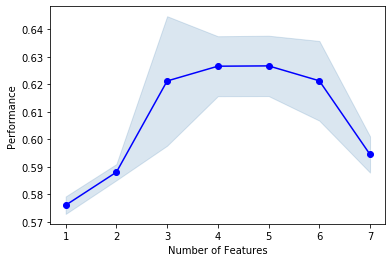

In [94]:
# Plot performance vs. number of features
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.show()

##### From above graph, we can see the the performance is best at 4 features.

In [95]:
# Which features are they the top 4 features?
sfs.k_feature_names_[0:4]

("city_King's Landing", 'phone_Android', 'phone_iPhone', 'avg_surge')

In [96]:
# Define X and y then split the data into train and test set
X = df_ml[["city_King's Landing", 'phone_Android', 'phone_iPhone', 'ultimate_black_user_False']]
y = df_ml['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3, stratify=y)

In [97]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [98]:
# Define StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3)

In [99]:
# StratifiedKFold train test split
for train_ix, test_ix in kf.split(X, y):
    train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

In [100]:
# Print cross validation score using StratifiedKFold
print('Average cross validation score: %.3f' % cross_val_score(lr, train_X, train_y, cv=kf, scoring='f1').mean())

Average cross validation score: 0.589


In [101]:
# Print precision, recall, f1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     12676
           1       0.58      0.61      0.60      7324

    accuracy                           0.70     20000
   macro avg       0.67      0.68      0.68     20000
weighted avg       0.70      0.70      0.70     20000



In [102]:
# Print confusion matrix
confusion_matrix(y_test, y_pred)

array([[9458, 3218],
       [2857, 4467]], dtype=int64)

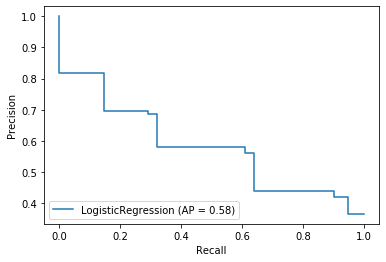

In [103]:
# Plot precision recall curve
plot_precision_recall_curve(lr, X_test, y_test)
plt.show()

## Random Forest

In [104]:
# Define RandomForestClassifier
rf = RandomForestClassifier(class_weight=weight, random_state=3)

In [105]:
# Define X and y then split the data into train and test set
X = df_ml.drop(['active'], axis=1)
y = df_ml['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3, stratify=y)

In [106]:
# Fit the data
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.7400327689787}, random_state=3)

In [107]:
# Predict y
y_pred2 = rf.predict(X_test)

In [108]:
# Print confusion matrix
confusion_matrix(y_test, y_pred2)

array([[10914,  1762],
       [ 2280,  5044]], dtype=int64)

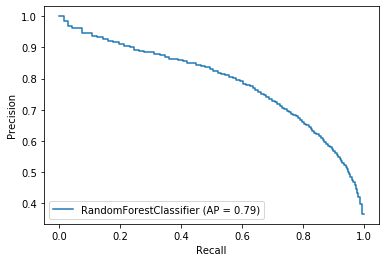

In [109]:
# Plot precision recall curve
plot_precision_recall_curve(rf, X_test, y_test)
plt.show()

## Sequential Forward Selection - Random Forest

In [110]:
# Sequential Forward Selection (SFS)
sfs2 = SFS(rf,
           k_features=7,
           forward=True,
           floating=False,
           scoring = 'f1',
           cv = 5)

In [111]:
sfs2.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(class_weight={0: 1,
                                                                         1: 1.7400327689787},
                                                           random_state=3),
                          k_features=7, scoring='f1')

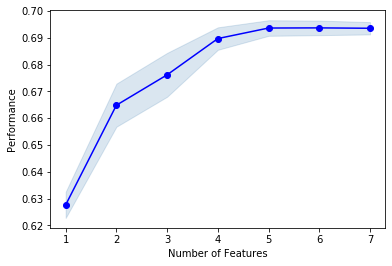

In [112]:
# Plot performance vs. number of features
plot_sfs(sfs2.get_metric_dict(), kind='std_dev')
plt.show()

##### From above graph, we can see the the performance is best at 4 features.

In [113]:
# Which features are they the top 4 features?
sfs2.k_feature_names_[0:4]

("city_King's Landing",
 'phone_Android',
 'phone_iPhone',
 'ultimate_black_user_False')

In [114]:
# Define X and y then split the data into train and test set
X = df_ml[["city_King's Landing", 'phone_Android', 'phone_iPhone', 'ultimate_black_user_False']]
y = df_ml['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3, stratify=y)

In [115]:
# Fit data and predict
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [116]:
# Define StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3)

In [117]:
# StratifiedKFold train test split
for train_ix, test_ix in kf.split(X, y):
    train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

In [118]:
# Print cross validation score using StratifiedKFold
print('Average cross validation score: %.3f' % cross_val_score(rf, train_X, train_y, cv=kf, scoring='f1').mean())

Average cross validation score: 0.589


In [119]:
# Print precision, recall, f1 score
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     12676
           1       0.58      0.61      0.60      7324

    accuracy                           0.70     20000
   macro avg       0.67      0.68      0.68     20000
weighted avg       0.70      0.70      0.70     20000



In [120]:
# Print confusion matrix
confusion_matrix(y_test, y_pred2)

array([[9458, 3218],
       [2857, 4467]], dtype=int64)

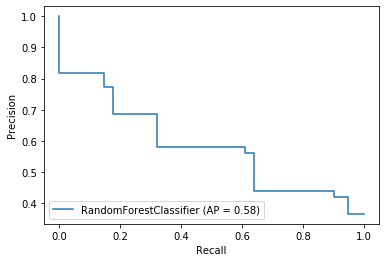

In [121]:
# Plot precision recall curve
plot_precision_recall_curve(rf, X_test, y_test)
plt.show()

Looking at the cross_val_score after feature reduction, both logistic regression and random forest performed the same. Also, their f1 score is same as well. From the features selected, the most important features were: "city_King's Landing", 'phone_Android', 'phone_iPhone', 'ultimate_black_user_False.